In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import cv2
import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.models import  Model,load_model
from keras.callbacks import EarlyStopping,ModelCheckpoint
from google.colab.patches import cv2_imshow
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing import image
from sklearn.metrics import classification_report, confusion_matrix
from keras.applications.vgg16 import VGG16
import datetime
from tensorflow import keras

In [ ]:
def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

In [ ]:

img_height , img_weight = (244,244)
batch_size = 32
train_data_dir = r"/content/gdrive/MyDrive/m244/train"
test_data_dir = r"/content/gdrive/MyDrive/final test/test"
valid_data_dir = r"/content/gdrive/MyDrive/m244/valid"

class_names=os.listdir(train_data_dir)
class_names_test=os.listdir(test_data_dir)
class_names_val=os.listdir(valid_data_dir)

In [ ]:
print(class_names)
print(class_names_test)
print(class_names_val)

['Chromophobe', 'Oncocytoma']
['Oncocytoma', 'Chromophobe']
['Oncocytoma', 'Chromophobe']


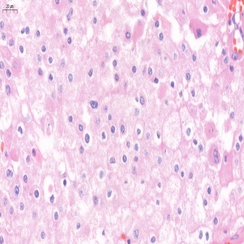

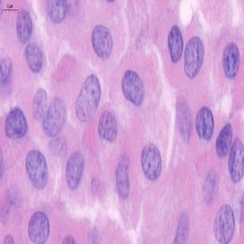

In [ ]:
#Sample datasets images
image_chromophobe=cv2.imread("/content/gdrive/MyDrive/m244/test/Chromophobe/2021-02-17T21-09-43-R2-S5_41-2x-resized_jpg.rf.4fbec9a5d3696202377b54aaccd81d91 resized.jpg")
cv2_imshow(image_chromophobe)
image_oncocytoma=cv2.imread("/content/gdrive/MyDrive/m244/test/Oncocytoma/2021-02-17T23-00-42-R3-S1_167-0x-resized_jpg.rf.f4b2d52e3aad835abffaede96c89ba00 resized.jpg")
cv2_imshow(image_oncocytoma)

In [ ]:
train_datagen = ImageDataGenerator(zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.15)
test_datagen = ImageDataGenerator()

In [ ]:
train_generator = train_datagen.flow_from_directory("/content/gdrive/MyDrive/m244/train",target_size=(224, 224),batch_size=32,shuffle=True,class_mode='categorical')
test_generator = test_datagen.flow_from_directory("/content/gdrive/MyDrive/final test/test",target_size=(224,224),batch_size=32,shuffle=False,class_mode='categorical')
valid_generator = test_datagen.flow_from_directory("/content/gdrive/MyDrive/m244/valid",target_size=(224,224),batch_size=32,shuffle=False,class_mode='categorical')
x,y = test_generator.next()
x.shape

Found 948 images belonging to 2 classes.
Found 68 images belonging to 2 classes.
Found 274 images belonging to 2 classes.


(32, 224, 224, 3)

In [ ]:
logdir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

base_model =VGG16(include_top = False , weights = 'imagenet')
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(500 , activation='relu')(x)
predictions = Dense(train_generator.num_classes , activation = 'softmax')(x)
model = Model(inputs=base_model.input , outputs = predictions)

for layer in base_model.layers:
    layer.trainable = True

es=EarlyStopping(monitor='val_accuracy', mode='auto', verbose=1, patience=10,restore_best_weights=True,)
mc = ModelCheckpoint('/content/gdrive/MyDrive/models/bestvgg16_model.h5', monitor='val_accuracy')
model.compile(optimizer='adam' , loss = 'categorical_crossentropy' , metrics=['accuracy'])
model.fit_generator(train_generator,validation_data=test_generator,epochs=100,verbose=1,callbacks=[mc,es])


model.save('/content/gdrive/MyDrive/models/bestvgg16_model.h5')

<ipython-input-27-e18ea46846a8>:29: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator,validation_data=test_generator,epochs=100,verbose=1,callbacks=[mc,es])


Epoch 1/100
30/30 [==============================] - 21s 671ms/step - loss: 304.0351 - accuracy: 0.5084 - val_loss: 0.7155 - val_accuracy: 0.5294
Epoch 2/100
30/30 [==============================] - 20s 650ms/step - loss: 0.7002 - accuracy: 0.5359 - val_loss: 0.7022 - val_accuracy: 0.4706
Epoch 3/100
30/30 [==============================] - 20s 665ms/step - loss: 0.7051 - accuracy: 0.5369 - val_loss: 0.6993 - val_accuracy: 0.4706
Epoch 4/100
30/30 [==============================] - 20s 650ms/step - loss: 0.6999 - accuracy: 0.5137 - val_loss: 0.6991 - val_accuracy: 0.4706
Epoch 5/100
30/30 [==============================] - 20s 667ms/step - loss: 0.7008 - accuracy: 0.4895 - val_loss: 0.6914 - val_accuracy: 0.5294
Epoch 6/100
30/30 [==============================] - 20s 664ms/step - loss: 0.6930 - accuracy: 0.5000 - val_loss: 0.6921 - val_accuracy: 0.5882
Epoch 7/100
30/30 [==============================] - 24s 783ms/step - loss: 0.6927 - accuracy: 0.5327 - val_loss: 0.7012 - val_accurac

In [ ]:
#model.load_weights("/content/gdrive/My Drive/models/bestvgg16_model.h5")
my_model = keras.models.load_model("/content/gdrive/My Drive/models/bestvgg16_model.h5")

In [ ]:
my_model.evaluate_generator(test_generator)


<ipython-input-14-f9d0adee41f6>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  my_model.evaluate_generator(test_generator)


[2.1636500358581543, 0.8235294222831726]

In [ ]:
model.evaluate_generator(test_generator)


<ipython-input-30-faa0e9406f88>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(test_generator)


[2.1636502742767334, 0.8235294222831726]

In [ ]:
Y_pred = model.predict_generator(valid_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(valid_generator.classes, y_pred))
print('Classification Report')
target_names = ['Oncocytoma', 'Chromophobe',]
print(classification_report(valid_generator.classes, y_pred, target_names=target_names))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


Confusion Matrix
[[111  10]
 [  2 151]]
Classification Report
              precision    recall  f1-score   support

  Oncocytoma       0.98      0.92      0.95       121
 Chromophobe       0.94      0.99      0.96       153

    accuracy                           0.96       274
   macro avg       0.96      0.95      0.96       274
weighted avg       0.96      0.96      0.96       274



In [ ]:
Y_pred = my_model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
target_names = ['Oncocytoma', 'Chromophobe',]
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

<ipython-input-16-56c49d0d2cc9>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = my_model.predict_generator(test_generator)


Confusion Matrix
[[34  2]
 [10 22]]
Classification Report
              precision    recall  f1-score   support

  Oncocytoma       0.77      0.94      0.85        36
 Chromophobe       0.92      0.69      0.79        32

    accuracy                           0.82        68
   macro avg       0.84      0.82      0.82        68
weighted avg       0.84      0.82      0.82        68

